In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import shutil
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import  ReduceLROnPlateau, EarlyStopping

In [2]:
# Transfering the variables from the preprocessing notebook
%store -r train_dir
%store -r val_dir
%store -r test_dir
%store -r val_datagen
%store -r test_datagen

In [3]:
# A basic rescaling for the preparation of the images
train_datagen = ImageDataGenerator(
    rescale = 1./255.)

Setting input size, batch size and class mode for ever generator

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    batch_size = 20,
    target_size = (224, 224),
    class_mode = 'categorical')

Found 17510 images belonging to 5 classes.


In [5]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    batch_size = 20,
    target_size = (224, 224),
    class_mode = 'categorical')

Found 5025 images belonging to 5 classes.


In [6]:
test_generator = test_datagen.flow_from_directory(
    directory = test_dir,
    batch_size = 2,
    target_size = (224, 224),
    class_mode = None,
    shuffle = False)

Found 2465 images belonging to 5 classes.


In [7]:
#Adding an inceptionv3 pre-trained model 
base_model = InceptionV3(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

2021-09-03 13:43:02.751979: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
#By setting each layer into False we "freeze" them
#A frozen layer won't be updated during training 
for layer in base_model.layers:
    layer.trainable = False

In [9]:
import tensorflow as tf
x = tf.keras.layers.Flatten()(base_model.output)

In [10]:
x = tf.keras.layers.Dense(1024, activation='relu')(x)

In [11]:
x = tf.keras.layers.Dropout(0.25)(x)

In [12]:
x = tf.keras.layers.Dense(5, activation='softmax')(x)

In [13]:
model = tf.keras.models.Model(base_model.input, x)

In [14]:
model.compile(optimizer = RMSprop(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [16]:
callbacks = [  
    # Stop training when val_loss has stopped improving
    EarlyStopping(monitor = 'val_loss',
                  patience = 3,
                  verbose = 1,
                  restore_best_weights = True),
    # Reduce learning rate when val_loss has stopped improving
    ReduceLROnPlateau(monitor = 'val_loss',
                      factor = 0.1,
                      patience = 3,
                      verbose = 1)
]

In [17]:
inc_history = model.fit(train_generator, validation_data = val_generator, steps_per_epoch = 20, epochs = 100, callbacks = callbacks)

2021-09-03 13:43:04.878539: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
20/20 [==============================] - 200s 10s/step - loss: 6.5485 - accuracy: 0.5825 - val_loss: 1.0855 - val_accuracy: 0.7871
Epoch 2/100
20/20 [==============================] - 205s 11s/step - loss: 1.1441 - accuracy: 0.7575 - val_loss: 4.3766 - val_accuracy: 0.7339
Epoch 3/100
20/20 [==============================] - 204s 11s/step - loss: 1.2011 - accuracy: 0.8200 - val_loss: 0.4950 - val_accuracy: 0.8728
Epoch 4/100
20/20 [==============================] - 204s 11s/step - loss: 0.8225 - accuracy: 0.8225 - val_loss: 0.4092 - val_accuracy: 0.8870
Epoch 5/100
20/20 [==============================] - 203s 11s/step - loss: 0.8443 - accuracy: 0.8325 - val_loss: 0.7394 - val_accuracy: 0.8253
Epoch 6/100
20/20 [==============================] - 204s 11s/step - loss: 0.5741 - accuracy: 0.8750 - val_loss: 0.8220 - val_accuracy: 0.8344
Epoch 7/100
20/20 [==============================] - 204s 11s/step - loss: 0.6937 - accuracy: 0.8575 - val_loss: 0.2158 - val_accuracy: 0.9363

In [18]:
#Saving the model's weights and architecture
model.save('Inceptionv3-1.h5')

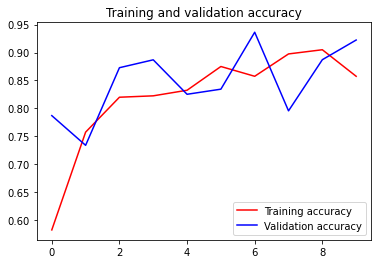

<Figure size 432x288 with 0 Axes>

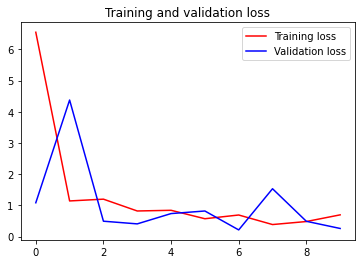

<Figure size 432x288 with 0 Axes>

In [19]:
#Plotting the metrics
import matplotlib.pyplot as plt

acc = inc_history.history['accuracy']
val_acc = inc_history.history['val_accuracy']
loss = inc_history.history['loss']
val_loss = inc_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

Preparing the inputs for the confusion matrix and classification report

In [20]:
pred_probs = model.predict(test_generator,verbose = 2)

1233/1233 - 121s


In [21]:
predicted_indices = np.argmax(pred_probs, axis=1)

In [22]:
# The predicted classes of the test set as an integer
predicted_indices

array([0, 0, 0, ..., 4, 0, 4])

In [23]:
# The default classes of the test directory as an integer
test_generator.classes

array([0, 0, 0, ..., 4, 4, 4], dtype=int32)

In [24]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true = test_generator.classes, y_pred = predicted_indices)

In [25]:
cm

array([[476,   8,   5,   0,   4],
       [ 11, 481,   1,   0,   0],
       [ 27,   2, 426,  14,  24],
       [  1,   0,   1, 491,   0],
       [ 15,   2,  54,   2, 420]])

In [26]:
target_names = ["colon_aca","colon_n","lung_aca","lung_n","lung_scc",]

In [27]:
pd.DataFrame(cm,
             columns = target_names,
             index= target_names)

,colon_aca,colon_n,lung_aca,lung_n,lung_scc
colon_aca,476,8,5,0,4
colon_n,11,481,1,0,0
lung_aca,27,2,426,14,24
lung_n,1,0,1,491,0
lung_scc,15,2,54,2,420


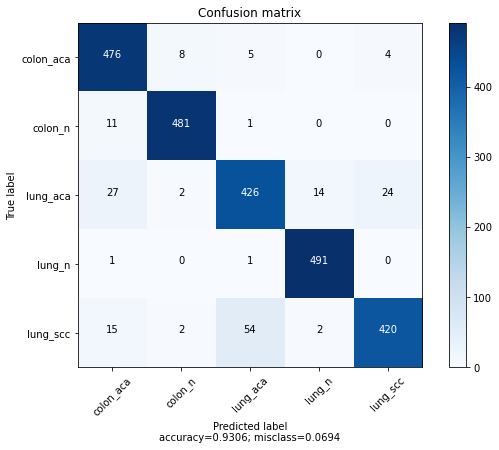

In [28]:
# Plotting a confusion matrix with extra features and a more analytical display
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
plot_confusion_matrix(cm,target_names)


In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_true = test_generator.classes, y_pred = predicted_indices, target_names = target_names))

              precision    recall  f1-score   support

   colon_aca       0.90      0.97      0.93       493
     colon_n       0.98      0.98      0.98       493
    lung_aca       0.87      0.86      0.87       493
      lung_n       0.97      1.00      0.98       493
    lung_scc       0.94      0.85      0.89       493

    accuracy                           0.93      2465
   macro avg       0.93      0.93      0.93      2465
weighted avg       0.93      0.93      0.93      2465



The comments for the commands will not be repeated in the second model since the parameters and the structure is the same

In [30]:
#Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2,
    shear_range = 0.2, 
    zoom_range = 0.2, 
    horizontal_flip = True)

In [31]:
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    batch_size = 20,
    target_size = (224, 224),
    class_mode = 'categorical')

Found 17510 images belonging to 5 classes.


In [32]:
base_model = InceptionV3(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

In [33]:
for layer in base_model.layers:
    layer.trainable = False

In [34]:
x = tf.keras.layers.Flatten()(base_model.output)

In [35]:
x = tf.keras.layers.Dense(1024, activation='relu')(x)

In [36]:
x = tf.keras.layers.Dropout(0.25)(x)

In [37]:
x = tf.keras.layers.Dense(5, activation='softmax')(x)

In [38]:
model2 = tf.keras.models.Model(base_model.input, x)

In [39]:
model2.compile(optimizer = RMSprop(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [40]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [41]:
callbacks = [  
    EarlyStopping(monitor = 'val_loss',
                  patience = 3,
                  verbose = 1,
                  restore_best_weights = True),
    ReduceLROnPlateau(monitor = 'val_loss',
                      factor = 0.1,
                      patience = 3,
                      verbose = 1)
]

In [42]:
inc_history2 = model2.fit(train_generator, validation_data = val_generator, steps_per_epoch = 20, epochs = 100, callbacks = callbacks)

Epoch 1/100
20/20 [==============================] - 209s 11s/step - loss: 11.3141 - accuracy: 0.3450 - val_loss: 0.7966 - val_accuracy: 0.7795
Epoch 2/100
20/20 [==============================] - 203s 11s/step - loss: 1.3314 - accuracy: 0.7125 - val_loss: 1.1529 - val_accuracy: 0.7741
Epoch 3/100
20/20 [==============================] - 198s 10s/step - loss: 1.5840 - accuracy: 0.7200 - val_loss: 1.4808 - val_accuracy: 0.6559
Epoch 4/100
20/20 [==============================] - 198s 10s/step - loss: 1.0321 - accuracy: 0.7825 - val_loss: 0.6182 - val_accuracy: 0.8207
Epoch 5/100
20/20 [==============================] - 196s 10s/step - loss: 1.4821 - accuracy: 0.7000 - val_loss: 0.5055 - val_accuracy: 0.8370
Epoch 6/100
20/20 [==============================] - 195s 10s/step - loss: 0.5705 - accuracy: 0.8400 - val_loss: 0.4196 - val_accuracy: 0.8593
Epoch 7/100
20/20 [==============================] - 196s 10s/step - loss: 0.7391 - accuracy: 0.8025 - val_loss: 0.4950 - val_accuracy: 0.863

In [43]:
model2.save('Inceptionv3-2.h5')

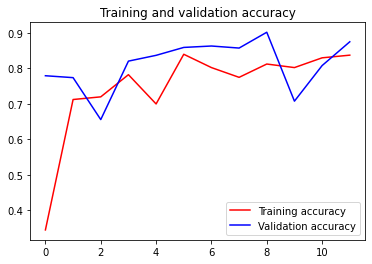

<Figure size 432x288 with 0 Axes>

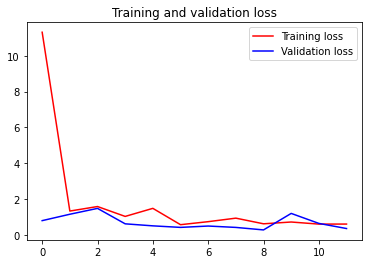

<Figure size 432x288 with 0 Axes>

In [44]:
import matplotlib.pyplot as plt

acc = inc_history2.history['accuracy']
val_acc = inc_history2.history['val_accuracy']
loss = inc_history2.history['loss']
val_loss = inc_history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

Preparing the inputs for the confusion matrix and classification report

In [45]:
pred_probs2 = model2.predict(test_generator,verbose = 2)

1233/1233 - 116s


In [46]:
predicted_indices2 = np.argmax(pred_probs2, axis=1)

In [47]:
predicted_indices2

array([0, 0, 0, ..., 4, 4, 4])

In [48]:
test_generator.classes

array([0, 0, 0, ..., 4, 4, 4], dtype=int32)

In [49]:
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(y_true = test_generator.classes, y_pred = predicted_indices2)

In [50]:
cm2

array([[432,   6,  31,   3,  21],
       [ 10, 468,   4,   0,  11],
       [  9,   1, 380,  25,  78],
       [  0,   0,   1, 492,   0],
       [  7,   2,  37,   1, 446]])

In [51]:
target_names = ["colon_aca","colon_n","lung_aca","lung_n","lung_scc",]

In [52]:
pd.DataFrame(cm2,
             columns = target_names,
             index= target_names)

,colon_aca,colon_n,lung_aca,lung_n,lung_scc
colon_aca,432,6,31,3,21
colon_n,10,468,4,0,11
lung_aca,9,1,380,25,78
lung_n,0,0,1,492,0
lung_scc,7,2,37,1,446


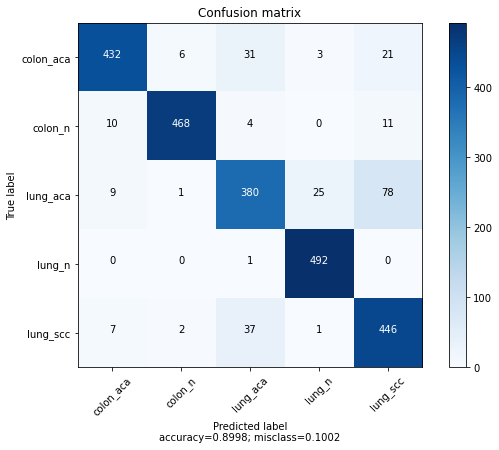

In [53]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
plot_confusion_matrix(cm2,target_names)


In [54]:
from sklearn.metrics import classification_report
print(classification_report(y_true = test_generator.classes, y_pred = predicted_indices2, target_names = target_names))

              precision    recall  f1-score   support

   colon_aca       0.94      0.88      0.91       493
     colon_n       0.98      0.95      0.96       493
    lung_aca       0.84      0.77      0.80       493
      lung_n       0.94      1.00      0.97       493
    lung_scc       0.80      0.90      0.85       493

    accuracy                           0.90      2465
   macro avg       0.90      0.90      0.90      2465
weighted avg       0.90      0.90      0.90      2465

